In [1]:
%matplotlib inline


# Load an FVCOM model output and plot a surface.
from PyFVCOM.read import FileReader
from PyFVCOM.plot import Plotter, Time, Depth
from PyFVCOM.tide import make_water_column
from cmocean import cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import xarray as xr
from datetime import datetime,timedelta
from mpl_toolkits.basemap import Basemap

from scipy.io import loadmat

import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
#from pykrige.ok3d import OrdinaryKriging3D
import datetime

from scipy.spatial import cKDTree as KDTree

In [2]:
class Invdisttree:
        """ inverse-distance-weighted interpolation using KDTree:
        invdisttree = Invdisttree( X, z )  -- points, values
        interpol = invdisttree( q, k=6, eps=0 )
            -- interpolate z from the 6 points nearest each q;
               q may be one point, or a batch of points
        """
        def __init__( self, X, z, leafsize=10 ):
            self.tree = KDTree( X, leafsize=leafsize )  # build the tree
            self.z = z

        def __call__( self, q, k=6, eps=0 ):
                # k nearest neighbours of each query point --
            self.distances, self.ix = self.tree.query( q, k=k, eps=eps )
            interpol =  np.zeros( (len(self.distances),) +np.shape(self.z[...,0]) )
            #print(self.ix.shape)
            tmp = 0
            for dist, ix in zip( self.distances, self.ix ):
                if dist[0] > 1e-10:
                    w = 1 / dist
                    
                    wz = np.dot( self.z[...,ix] ,w) / np.sum(w)  # weight z s by 1/dist
                    #print(wz.shape)
                else:
                    wz = self.z[...,ix[0]]
                interpol[tmp,] = wz  
                tmp += 1
                #interpol.append( wz )
            return interpol
        
def make_map(ax=None,llcrnrlon=-49, urcrnrlon=-39, llcrnrlat=-30, urcrnrlat=-21,lat_0 = -80, lon_0 = 115,
             projection='merc', resolution='h', figsize=(6, 6), inset=True, epsg = 2933):
    m = Basemap(llcrnrlon=llcrnrlon, urcrnrlon=urcrnrlon,
                llcrnrlat=llcrnrlat, urcrnrlat=urcrnrlat,
                projection = projection, resolution=resolution, lat_0 = lat_0,lon_0 = lon_0)
    m.drawstates()
    #m.drawcoastlines()
    #m.fillcontinents(color='0.85',zorder = 0)
    meridians = np.arange(115.65, urcrnrlon + 2, 0.05)
    parallels = np.arange(-32.3, urcrnrlat + 2, 0.05)
    m.drawparallels(parallels, linewidth=0, labels=[1, 0, 0, 0])
    m.drawmeridians(meridians, linewidth=0, labels=[0, 0, 0, 1])
    m.llcrnrlon = llcrnrlon
    m.urcrnrlon = urcrnrlon
    m.llcrnrlat = llcrnrlat
    m.urcrnrlat = urcrnrlat
    
    m.ax = ax
    return m
def draw_par(plot):
    plot.axes.set_xlim(right=(distance / 1000).max()) 
    plot.axes.set_ylim(top=5) # set the x-axis to the data range
    plot.axes.set_xlabel('Distance (km)')
    plot.axes.set_ylabel('Depth (m)')

    plt.text(0.82,0.1, r'$scale:$', color='r',transform=plot.axes.transAxes, fontweight=100, fontsize=18)
    plt.text(0.82,0.05, r'$0.1m/s$', color='r',transform=plot.axes.transAxes, fontweight=100, fontsize=18)
    plt.quiver(10.5, -21, 0.1, 0, color='r', width=0.001,scale=2)

In [3]:
datapath = '/public/home/gaoguandong/xrsh/work/pic/data/'

In [4]:
with open('zhouwei_fvcom.pkl', 'rb') as f:
    fvcom = pickle.load(f)
    

with open(datapath + 'wannei_normal.pkl', 'rb') as f:
    fvcom2 = pickle.load(f)
    fvcom2 = fvcom2['normal']

with open('CS_loc.pkl', 'rb') as f:
    duanmian = pickle.load(f)

In [5]:
llcrnrlon=115.64
urcrnrlon=115.78
llcrnrlat=-32.29
urcrnrlat=-32.11
fig = plt.figure(figsize = (10,15) )
ax = fig.add_subplot(1,1,1)

m = make_map(llcrnrlon=llcrnrlon, urcrnrlon=urcrnrlon, llcrnrlat=llcrnrlat, urcrnrlat=urcrnrlat, figsize=(20, 10)
             ,ax =ax,epsg=32750, lat_0 = -80, lon_0 = 110)
plt.close()

In [6]:
np.append(duanmian['B'][0],duanmian['C'][0])

array([115.70015015, 115.70092644, 115.70170273, 115.70247902,
       115.70325531, 115.70011963, 115.69989838, 115.69967713])

In [7]:
dx,dy = m(np.append(duanmian['B'][0],duanmian['C'][0]),np.append(duanmian['B'][1],duanmian['C'][1]))
zx,zy = m(fvcom.grid.lon,fvcom.grid.lat)
zex,zey = m(fvcom.grid.lonc,fvcom.grid.latc)

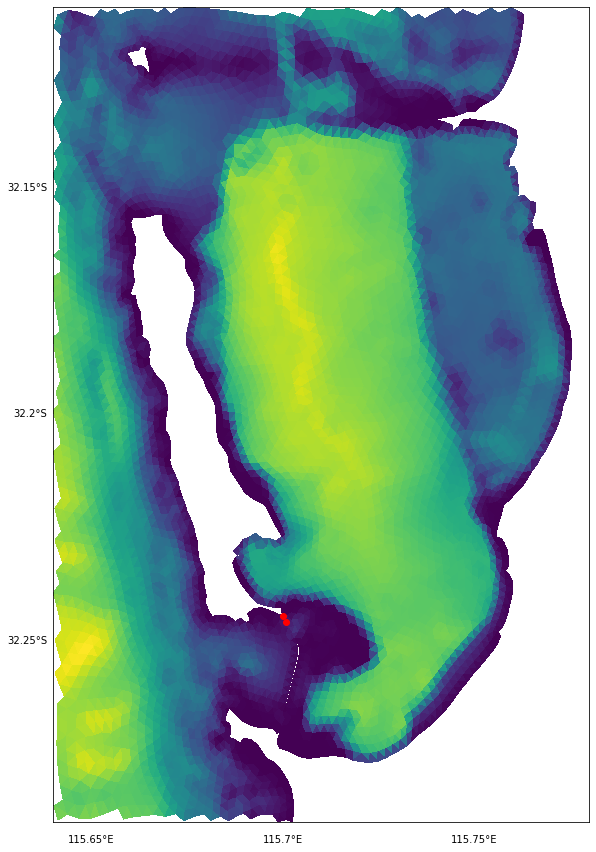

In [18]:
fig = plt.figure(figsize = (10,15) )
ax = fig.add_subplot(1,1,1)
m = make_map(llcrnrlon=llcrnrlon, urcrnrlon=urcrnrlon, llcrnrlat=llcrnrlat, urcrnrlat=urcrnrlat, figsize=(20, 10)
             ,ax =ax,epsg=32750, lat_0 = -80, lon_0 = 110)
triangles = fvcom2.grid.nv.transpose() - 1
[xx,yy] = m(fvcom2.grid.lon,fvcom2.grid.lat)
tp2 = m.ax.tripcolor(xx, yy, triangles,fvcom2.grid.h)
m.ax.facecolor = 0.85
#m.ax.scatter(zex,zey,facecolor = 'red')
m.ax.scatter(dx[:2],dy[:2],facecolor = 'red')

In [9]:
Xe = np.zeros((zex.shape[0],2))
Xe[:,0] = zex
Xe[:,1] = zey

Xn = np.zeros((zx.shape[0],2))
Xn[:,0] = zx
Xn[:,1] = zy

dloc = np.zeros((8,2))
dloc[:,0] = dx
dloc[:,1] = dy

invdisttree = Invdisttree( Xn, fvcom.grid.h ) 
hh = invdisttree( dloc, k=8, eps=0 )

In [10]:
invdisttree = Invdisttree( Xn, fvcom.data.temp ) 
temp = invdisttree( dloc, k=8, eps=0 )

invdisttree = Invdisttree( Xn, fvcom.data.zeta ) 
zeta = invdisttree( dloc, k=8, eps=0 )

invdisttree = Invdisttree( Xe, fvcom.data.u ) 
u = invdisttree( dloc, k=8, eps=0 )
invdisttree = Invdisttree( Xe, fvcom.data.v ) 
v = invdisttree( dloc, k=8, eps=0 )

In [19]:
ds = xr.Dataset({'temp': (('loc','time','depth'),temp),
                'u':     (('loc','time','depth'),u),
                'v' :     (('loc','time','depth'),v),
                'lon' :     (('loc'),np.append(duanmian['B'][0],duanmian['C'][0])),
                'lat' :     (('loc'),np.append(duanmian['B'][1],duanmian['C'][1])),
                'x' :     (('loc'),dx),
                'y' :     (('loc'),dy),
                'h' :     (('loc'),hh),
                'zeta':   (('loc','time'),zeta)},
                                  coords={'time':fvcom.time.datetime,'loc':[0,0,0,0,0,1,1,1],'depth':np.arange(0,20)})

In [20]:
#ds = ds.sortby('lon')
with open('duanmian.pkl','wb') as f:
    pickle.dump(ds,f)